# Распознавание объектов на изображениях с помощью сверточных нейронных сетей






##Недостатки полносвязных (многослойных) нейронных сетей


1.   Большое количество весов для обучения (28х28 = 784 входа и 400 + 10 нейронов => 638810 весов)

2.  Изображение представляется в виде плоского массива => теряется информация о топологии






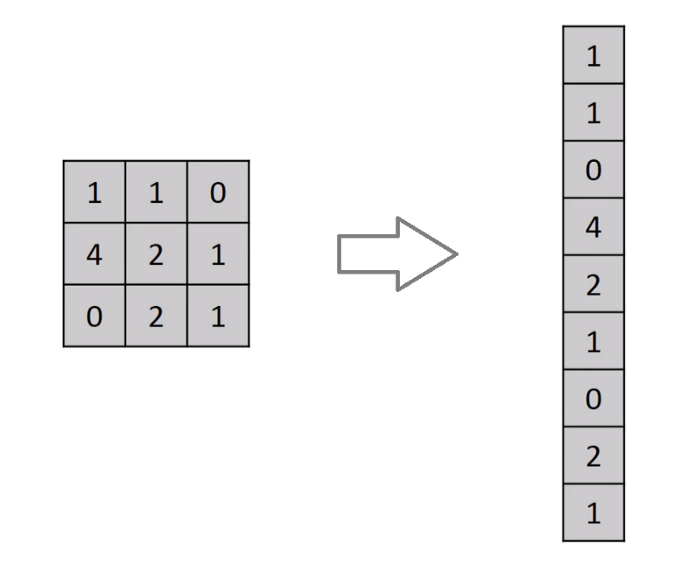

##Сверточные нейронные сети

Свёрточная нейронная сеть (англ. convolutional neural network, CNN) — специальная архитектура искусственных нейронных сетей, предложенная Яном Лекуном в 1988 году и нацеленная на эффективное распознавание образов. Использует некоторые представления об особенностях зрительной коры мозга.

Сверточные нейронные сети обеспечивают частичную устойчивость к изменениям масштаба, смещениям, поворотам, смене ракурса и прочим искажениям.

CNN состоит из разных видов слоев: сверточные (convolutional) слои, субдискретизирующие (sub-sampling или pooling layers, подвыборка) слои и слои «обычной» нейронной сети – персептрона

![4r8-t4d26oc1pw5tt3pd373qa2g[1].png](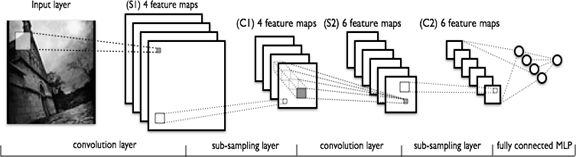)

Первые два типа слоев (convolutional, subsampling или pooling layers), чередуясь между собой, формируют входной вектор признаков для многослойного персептрона. 

Название архитектура сети получила из-за наличия операции свёртки, суть которой в том, что каждый фрагмент изображения умножается на матрицу (ядро)

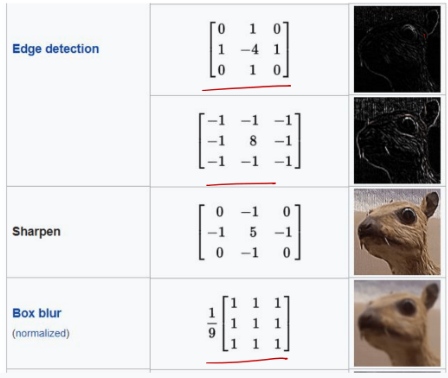

свёртки поэлементно, а результат суммируется и записывается в аналогичную позицию выходного изображения.

![2D_Convolution_Animation[1].gif](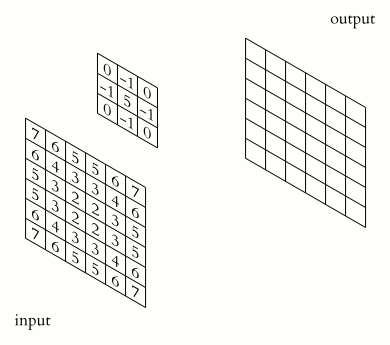)

![2d-covolutions[1].gif](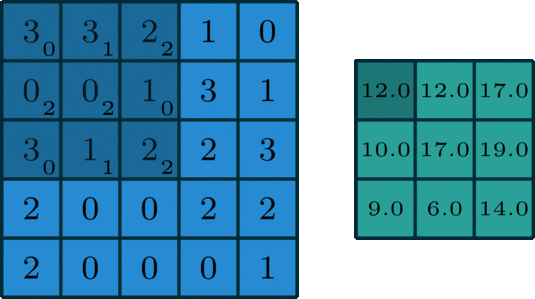)

Работа свёрточной нейронной сети обычно интерпретируется как переход от конкретных особенностей изображения к более абстрактным деталям, и далее к ещё более абстрактным деталям вплоть до выделения понятий высокого уровня. При этом сеть самонастраивается и вырабатывает сама необходимую иерархию абстрактных признаков (последовательности карт признаков), фильтруя маловажные детали и выделяя существенное.



Слой пулинга (иначе подвыборки, субдискретизации) представляет собой нелинейное уплотнение карты признаков, при этом группа пикселей (обычно размера 2×2) уплотняется до одного пикселя, проходя нелинейное преобразование. Наиболее употребительна при этом функция максимума. Преобразования затрагивают непересекающиеся прямоугольники или квадраты, каждый из которых ужимается в один пиксель, при этом выбирается пиксель, имеющий максимальное значение. Операция пулинга позволяет существенно уменьшить пространственный объём изображения. Пулинг интерпретируется так: если на предыдущей операции свёртки уже были выявлены некоторые признаки, то для дальнейшей обработки настолько подробное изображение уже не нужно, и оно уплотняется до менее подробного. К тому же фильтрация уже ненужных деталей помогает не переобучаться. Слой пулинга, как правило, вставляется после слоя свёртки перед слоем следующей свёртки.

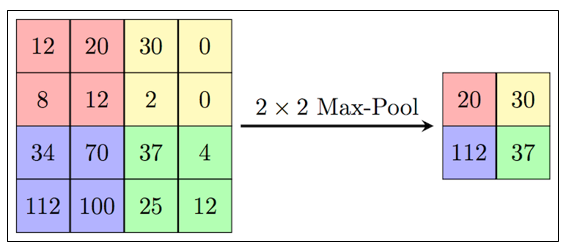

Может быть так:


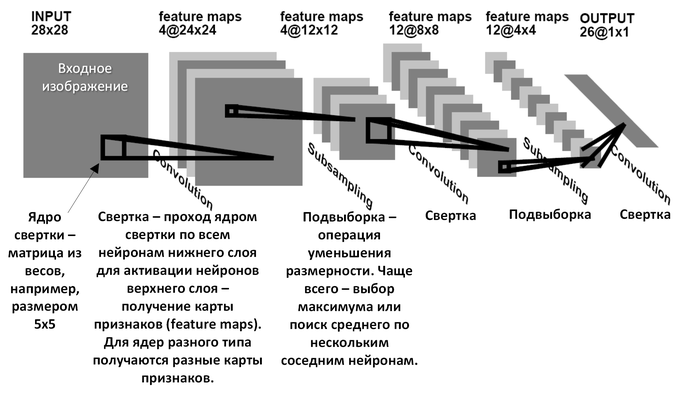

##Работа с набором данных fashion_mnist

Fashion MNIST содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого. Изображения содержат предметы одежды в разрешении 28х28 пикселей.

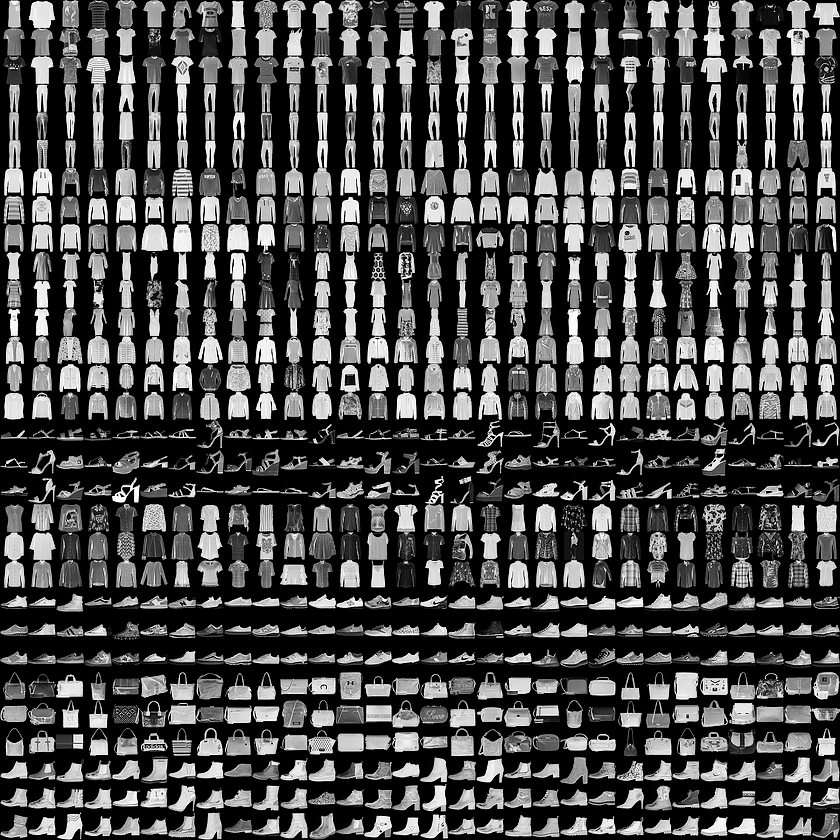

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.datasets import mnist
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline 

Создадим список с названиями классов

In [2]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

## Подготовка данных для обучения сети

**Загрузим данные**

In [3]:
batch_size = 100 # Размер мини-выборки
nb_classes = 10 # Количество классов изображений
nb_epoch = 25 # Количество эпох для обучения
img_rows, img_cols = 28, 28 # Размер изображений

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


и отобобразим часть изображений

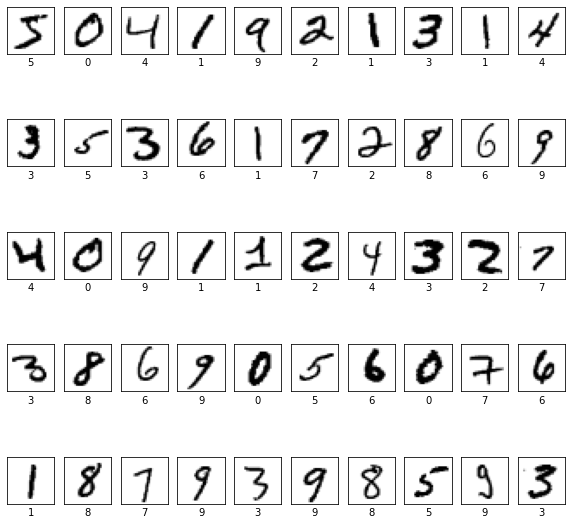

In [5]:
plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(classes[y_train[i]])

**Преобразование размерности и нормализация данных**

Значение интенсивности пикселей в изображении находится в интервале [0,255]. Для наших целей их необходимо нормализовать - привести к значениям в интервале [0,1].

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Посмотрим, как выглядит ответ

In [7]:
n = 0
print(y_train[n])

5


Преобразуем метки классов в удобный для обучения нейронной сети формат **(one hot encoding)**

In [8]:
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

Теперь ответ выглядит так:

In [9]:
print(y_train[n])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Метка целевого класса в этом наборе имеет значение **1**

## Создаем нейронную сеть

Вот некоторые функции активации. В качестве функции активации используем для входного и последующих слоев ReLU, а для выходного слоя - SoftMax.

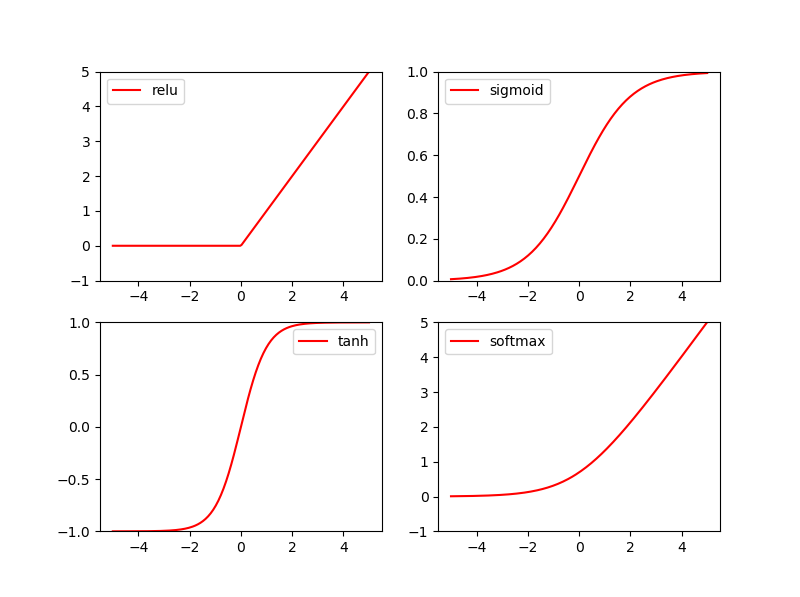

Конструируем нейронную сеть:

In [10]:
# Создаем последовательную модель нейронной сети
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(img_rows, (3, 3), padding='same',
                        input_shape=(img_rows, img_cols, 1), activation='relu'))
# Второй сверточный слой
model.add(Conv2D(img_rows, (3, 3), activation='relu', padding='same'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), padding='same', activation='relu'))
# Четвертый сверточный слой
model.add(Conv2D(2 * img_rows, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))
# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(8 * img_rows, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))
# Выходной полносвязный слой
model.add(Dense(nb_classes, activation='softmax'))

**Компилируем сеть**

Перед обучением модели ещё необходимо выполнить настройки при сборке модели (в методе compile):

* **loss** (функция потерь) - оценка желаемого значения относительно спрогнозированного, применим **categorical_crossentropy** (кроссэнтропию) - функцию штрафа, которую следует использовать для задач классификации, как у нас;
* **optimizer** (функция оптимизации) - агоритм "подгонки" внутренних параметров (весов и смещений) модели для минимизации функции потерь, optimizer="adam". Метод вычисляет индивидуальные адаптивные скорости обучения для различных параметров из оценок первого и второго моментов градиентов. Название получено из adaptive moment estimation - адаптивной оценки момента. Есть другие варианты [оптимизаторов](https://ru-keras.com/optimizer/);
* **metrics** (метрики) - используются для мониторинга процесса тренировки и тестирования, metrics=['accuracy'] значит, что мы будем вычислять в модели не только функцию штрафа, но и число правильно классифицированных примеров


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        280       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 28)        7084      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 28)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 28)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 56)        14168     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 56)        28280     
                                                        

## Обучаем нейронную сеть

In [12]:
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_split=0.2,
              shuffle=True,
              verbose=2)

Epoch 1/25
480/480 - 15s - loss: 0.2580 - accuracy: 0.9187 - val_loss: 0.0575 - val_accuracy: 0.9835 - 15s/epoch - 32ms/step
Epoch 2/25
480/480 - 4s - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.0392 - val_accuracy: 0.9880 - 4s/epoch - 7ms/step
Epoch 3/25
480/480 - 3s - loss: 0.0600 - accuracy: 0.9820 - val_loss: 0.0374 - val_accuracy: 0.9896 - 3s/epoch - 7ms/step
Epoch 4/25
480/480 - 3s - loss: 0.0474 - accuracy: 0.9850 - val_loss: 0.0289 - val_accuracy: 0.9916 - 3s/epoch - 7ms/step
Epoch 5/25
480/480 - 3s - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.0325 - val_accuracy: 0.9920 - 3s/epoch - 7ms/step
Epoch 6/25
480/480 - 4s - loss: 0.0347 - accuracy: 0.9890 - val_loss: 0.0288 - val_accuracy: 0.9920 - 4s/epoch - 7ms/step
Epoch 7/25
480/480 - 3s - loss: 0.0317 - accuracy: 0.9903 - val_loss: 0.0268 - val_accuracy: 0.9927 - 3s/epoch - 7ms/step
Epoch 8/25
480/480 - 3s - loss: 0.0293 - accuracy: 0.9908 - val_loss: 0.0268 - val_accuracy: 0.9930 - 3s/epoch - 7ms/step
Epoch 9/25
480/480 - 

## Оценка качества обучения

Проверка качества работы на наборе данных для тестирования

In [13]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(x_test, y_test, verbose=0)
print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

Точность работы на тестовых данных: 99.49%


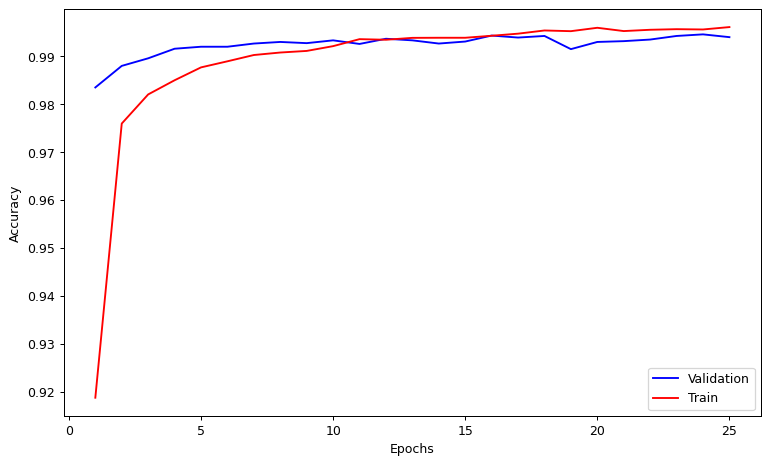

In [14]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Используем сеть для распознавания предметов одежды

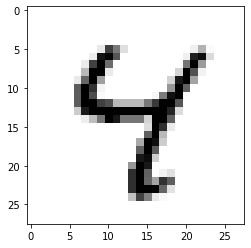

In [15]:
n_test = 6
plt.imshow(x_test[n_test].reshape(28, 28), cmap=plt.cm.binary)
plt.show()

**Запускаем распознавание и выводим результат**

In [16]:
x = x_test[n_test]
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
print(prediction)
prediction = np.argmax(prediction[0])
print("Номер класса:", prediction)
print("Название класса:", classes[prediction])

1/1 [==============================] - 0s 347ms/step
[[7.4466935e-20 6.1514980e-09 1.7554007e-14 3.0758827e-20 9.9999833e-01
  8.2297840e-15 2.1620709e-12 2.0487898e-11 5.0010399e-08 1.6242255e-06]]
Номер класса: 4
Название класса: 4


**Печатаем правильный ответ**

In [17]:
label = np.argmax(y_test[n_test])
print("Номер класса:", label)
print("Название класса:", classes[label])

Номер класса: 4
Название класса: 4


**Проверка на реальных картинках**

In [18]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('Файл(ы) "{name}" размером {length} байт загружен(ы)'.format(
      name=fn, length=len(uploaded[fn])))

Saving 9.jpg to 9.jpg
Saving 0.jpg to 0.jpg
Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg
Saving 4.jpg to 4.jpg
Saving 5.jpg to 5.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
Файл(ы) "9.jpg" размером 5344 байт загружен(ы)
Файл(ы) "0.jpg" размером 4415 байт загружен(ы)
Файл(ы) "1.jpg" размером 2738 байт загружен(ы)
Файл(ы) "2.jpg" размером 4650 байт загружен(ы)
Файл(ы) "3.jpg" размером 4523 байт загружен(ы)
Файл(ы) "4.jpg" размером 6189 байт загружен(ы)
Файл(ы) "5.jpg" размером 6925 байт загружен(ы)
Файл(ы) "6.jpg" размером 9374 байт загружен(ы)
Файл(ы) "7.jpg" размером 4673 байт загружен(ы)
Файл(ы) "8.jpg" размером 5407 байт загружен(ы)


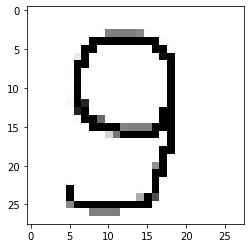

In [26]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline 
img_path = '9.jpg'
img = image.load_img(img_path, target_size=(28, 28), color_mode = "grayscale")
plt.imshow(img.convert('RGBA'))
plt.show()

In [27]:
x = image.img_to_array(img)
x = 255 - x
x /= 255
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
print(prediction)
prediction = np.argmax(prediction)
print("Номер класса:", prediction)
print("Название класса:", classes[prediction])

1/1 [==============================] - 0s 19ms/step
[[4.0309908e-10 9.7461414e-12 1.5184698e-07 2.6096488e-05 2.0539481e-03
  2.8685389e-07 1.0243762e-10 2.6253269e-07 1.4160573e-04 9.9777764e-01]]
Номер класса: 9
Название класса: 9
